In [1]:
import pandas as pd
import tensorflow as tf
import custom_metrics as cm
import sklearn as sk
import numpy as np
import math
import seaborn as sns
import data_preprocessing as dp
import expenditure_predictor as ep
import matplotlib.pyplot as plt
import feature_selection as fs
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras
from tensorflow.python.keras import layers
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn import svm

# Comparación entre modelos - Especificación log-lin

En este notebook aprovecharemos para llevar a cabo la comparación entre todos los conjuntos de variables obtenidos en el notebook seleccion_de_caracteristicas usando una especificación log-lin

# Subconjunto Literatura con selección por correlación 0.1


### Subconjunto Literatura correlacion 0.1 - Regresión Lineal con constante

In [21]:
literatura_corr1 = ['NOCHES', 'PERSONAS_TOTAL', 'INGRESOS', 'EDAD', 'ACTIV_PISCINA',
                    'ACTIV_PARQUES_OCIO', 'ALOJ_CATEG_HOTEL4', 'ALOJ_CATEG_HOTEL5',
                    'ALOJ_CATEG_PROPIA', 'PAQUETE_TURISTICO_ALGUNO_GRATIS',
                    'PAQUETE_TURISTICO_SI', 'NACIONALIDAD_ESP724']

#### Antes de evaluar los modelos con estas variables, vamos a echar un vistazo a su FIV para asegurarnos de que no haya multicolinealidad

In [17]:
X = dp.load_dataset('./datos/GASTO_TURISTICO_2018_ORIGINAL_2.csv', ';', ',', predictors=literatura_corr_log, dummies=True, desglose=False)
print(X.shape)
scaler = StandardScaler()

y = X.pop('GASTO')
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
fs.check_vif(X)

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\amct2\PycharmProjects\tfg\data_preprocessing.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = x[(y > q1 - IQR)]


(35767, 14)
         VIF                        variables
0   1.111014                           NOCHES
1   1.089733                   PERSONAS_TOTAL
2   1.077765                         INGRESOS
3   1.139802                             EDAD
4   1.145408                    ACTIV_PISCINA
5   1.056770             ACTIV_EXCURS_ORGANIZ
6   1.087288               ACTIV_PARQUES_OCIO
7   1.222241                ALOJ_CATEG_HOTEL4
8   1.083624                ALOJ_CATEG_HOTEL5
9   2.198837                ALOJ_CATEG_PROPIA
10  2.235518  PAQUETE_TURISTICO_ALGUNO_GRATIS
11  1.353002             PAQUETE_TURISTICO_SI
12  1.163010              NACIONALIDAD_ESP724


En principio parece que no hemos detectado ningún FIV alarmante (en torno a 5), por lo que procederemos a predecir con nuestro subconjunto.

In [18]:
X['GASTO'] = np.log(y)

train_dataset, test_dataset = dp.split_dataset(X)
train_labels = train_dataset.pop('GASTO')
test_labels = test_dataset.pop('GASTO')

### Subconjunto Literatura por correlación 0.1 - Regresión Lineal con constante

----Resultados sobre TRAIN----
R2:  0.3878919817956722
Adjusted R2:  0.3876180262452301
MAPE: 52.17048791368853
----Resultados sobre TEST----
R2:  0.3363889991987902
Adjusted R2:  0.33549714882253134
MAPE: 52.37181776727042


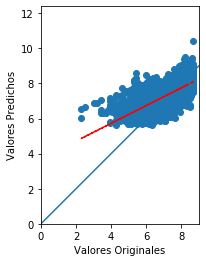

0.3363889991987902

In [5]:
lr = LinearRegression(fit_intercept=True)
lr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, lr)

### Subconjunto Literatura por correlación 0.1 - Random Forest

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  4.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


----Resultados sobre TRAIN----
R2:  0.8337525380711583
Adjusted R2:  0.8336781322251511
MAPE: 20.083884649036055
----Resultados sobre TEST----
R2:  0.4331518951924661
Adjusted R2:  0.43239008790635447
MAPE: 48.79159846377091


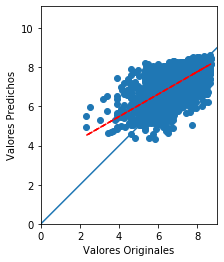

0.4331518951924661

In [6]:
regressor = RandomForestRegressor(100, criterion="mae", verbose=1, n_jobs=4)
regressor.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, regressor)

### Subconjunto Literatura con correlación 0.1 - Red Neuronal 

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________
None
Train on 17972 samples, validate on 8853 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/250
 - 1s - loss: 0.6435 - mean_absolute_error: 0.6435 - mean_squared_error: 1.2111 - val_

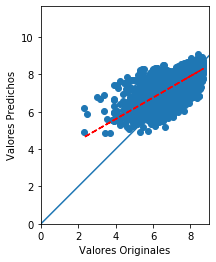

0.5031666017104585

In [7]:
model = ep.build_model(train_dataset)
print(model.summary())
ep.train_model(model, train_dataset, train_labels, 250)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, model)

### Subconjunto Literatura - Regresión de Soporte Vectorial

----Resultados sobre TRAIN----
R2:  0.3927923863670211
Adjusted R2:  0.39252062404553834
MAPE: 56.95779848398582
----Resultados sobre TEST----
R2:  0.33661562690560476
Adjusted R2:  0.3357240811023644
MAPE: 57.18917427371195


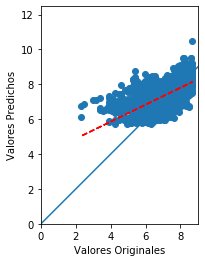

0.33661562690560476

In [8]:
svr = svm.SVR(kernel='linear')
svr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, svr)

# Subconjunto Literatura con RFE DecisionTreee


### Subconjunto Literatura - Regresión Lineal con constante

In [9]:
literatura_rfe = ['NOCHES', 'PERSONAS_TOTAL', 'INGRESOS', 'EDAD', 'ACTIV_PISCINA',
                  'ACTIV_PASEAR', 'ACTIV_ISLA', 'SEXO', 'ACTIV_GASTRONOMIA_CANARIA',
                  'ISLA_ES705', 'ISLA_ES709', 'PAQUETE_TURISTICO_PAGADO_POR_SEPARADO']

#### Antes de evaluar los modelos con estas variables, vamos a echar un vistazo a su FIV para asegurarnos de que no haya multicolinealidad

In [10]:
X = dp.load_dataset('./datos/GASTO_TURISTICO_2018_ORIGINAL_2.csv', ';', ',', predictors=literatura_rfe, dummies=True, desglose=False)
print(X.shape)
scaler = StandardScaler()

y = X.pop('GASTO')
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
fs.check_vif(X)

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\amct2\PycharmProjects\tfg\data_preprocessing.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = x[(y > q1 - IQR)]


(35767, 13)
         VIF                              variables
0   1.048762                                 NOCHES
1   1.064137                         PERSONAS_TOTAL
2   1.047677                               INGRESOS
3   1.122442                                   EDAD
4   1.090171                          ACTIV_PISCINA
5   1.113979                           ACTIV_PASEAR
6   1.148693                             ACTIV_ISLA
7   1.024825                                   SEXO
8   1.093536              ACTIV_GASTRONOMIA_CANARIA
9   1.282467                             ISLA_ES705
10  1.292805                             ISLA_ES709
11  1.034764  PAQUETE_TURISTICO_PAGADO_POR_SEPARADO


En principio parece que no hemos detectado ningún FIV alarmante (en torno a 5), por lo que procederemos a predecir con nuestro subconjunto.

In [11]:
X['GASTO'] = np.log(y)

train_dataset, test_dataset = dp.split_dataset(X)
train_labels = train_dataset.pop('GASTO')
test_labels = test_dataset.pop('GASTO')

### Subconjunto Literatura RFE - Red Neuronal 

Train on 17972 samples, validate on 8853 samples
Epoch 1/250
 - 1s - loss: 0.6714 - mean_absolute_error: 0.6714 - mean_squared_error: 1.1308 - val_loss: 0.4792 - val_mean_absolute_error: 0.4792 - val_mean_squared_error: 0.4285
Epoch 2/250
 - 1s - loss: 0.4425 - mean_absolute_error: 0.4425 - mean_squared_error: 0.3699 - val_loss: 0.4247 - val_mean_absolute_error: 0.4247 - val_mean_squared_error: 0.3560
Epoch 3/250
 - 1s - loss: 0.4225 - mean_absolute_error: 0.4225 - mean_squared_error: 0.3481 - val_loss: 0.4268 - val_mean_absolute_error: 0.4268 - val_mean_squared_error: 0.3778
Epoch 4/250
 - 1s - loss: 0.4123 - mean_absolute_error: 0.4123 - mean_squared_error: 0.3342 - val_loss: 0.4085 - val_mean_absolute_error: 0.4085 - val_mean_squared_error: 0.3361
Epoch 5/250
 - 1s - loss: 0.4062 - mean_absolute_error: 0.4062 - mean_squared_error: 0.3257 - val_loss: 0.4099 - val_mean_absolute_error: 0.4099 - val_mean_squared_error: 0.3510
Epoch 6/250
 - 1s - loss: 0.4025 - mean_absolute_error: 0.402

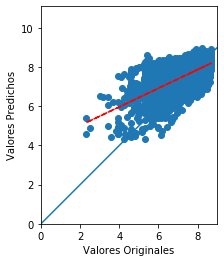

0.35167475765571254

In [12]:
model = ep.build_model(train_dataset)
ep.train_model(model, train_dataset, train_labels, 250)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, model)

### Subconjunto Literatura RFE - Regresión Lineal con constante

----Resultados sobre TRAIN----
R2:  0.146017329092487
Adjusted R2:  0.14563511993051137
MAPE: 66.12913646464254
----Resultados sobre TEST----
R2:  0.17282215621830566
Adjusted R2:  0.17171048255659882
MAPE: 65.4672470955939


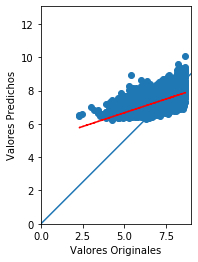

0.17282215621830566

In [13]:
lr = LinearRegression(fit_intercept=True)
lr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, lr)

### Subconjunto Literatura RFE - Random Forest

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


----Resultados sobre TRAIN----
R2:  0.8507370944081585
Adjusted R2:  0.8506647204656463
MAPE: 18.95138335125427
----Resultados sobre TEST----
R2:  0.43500807930932106
Adjusted R2:  0.4341853984212186
MAPE: 48.58911163177503


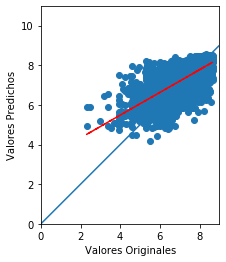

0.43500807930932106

In [22]:
regressor = RandomForestRegressor(100, criterion="mae", verbose=1, n_jobs=4)
regressor.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, regressor)

### Subconjunto Literatura RFE - Regresión de Soporte Vectorial

----Resultados sobre TRAIN----
R2:  0.3930079330313213
Adjusted R2:  0.3927136173821254
MAPE: 56.93739357496366
----Resultados sobre TEST----
R2:  0.3373683823890531
Adjusted R2:  0.3364035290031949
MAPE: 57.18141873101895


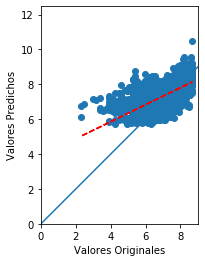

0.3373683823890531

In [23]:
svr = svm.SVR(kernel='linear')
svr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, svr)

# Subconjunto Literatura con RF


### Subconjunto Literatura - Regresión Lineal con constante

In [24]:
literatura_rf100 = ['EDAD', 'NOCHES', 'PERSONAS_TOTAL', 'INGRESOS', 'SEXO', 'ACTIV_PLAYA', 'ACTIV_ISLA', 'PRIMERA_VISITA_CANARIAS',
                    'ACTIV_PASEAR', 'ACTIV_PISCINA', 'ACTIV_GASTRONOMIA_CANARIA', 'ACTIV_OCIO']

#### Antes de evaluar los modelos con estas variables, vamos a echar un vistazo a su FIV para asegurarnos de que no haya multicolinealidad

In [25]:
X = dp.load_dataset('./datos/GASTO_TURISTICO_2018_ORIGINAL_2.csv', ';', ',', predictors=literatura_rf100, dummies=True, desglose=False)
print(X.shape)
scaler = StandardScaler()

y = X.pop('GASTO')
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
fs.check_vif(X)

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\amct2\PycharmProjects\tfg\data_preprocessing.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = x[(y > q1 - IQR)]


(35767, 13)
         VIF                  variables
0   1.219937                       EDAD
1   1.062578                     NOCHES
2   1.066991             PERSONAS_TOTAL
3   1.053754                   INGRESOS
4   1.024180                       SEXO
5   1.142317                ACTIV_PLAYA
6   1.163508                 ACTIV_ISLA
7   1.091509    PRIMERA_VISITA_CANARIAS
8   1.132425               ACTIV_PASEAR
9   1.114058              ACTIV_PISCINA
10  1.099140  ACTIV_GASTRONOMIA_CANARIA
11  1.059736                 ACTIV_OCIO


En principio parece que no hemos detectado ningún FIV alarmante (en torno a 5), por lo que procederemos a predecir con nuestro subconjunto.

In [26]:
X['GASTO'] = np.log(y)

train_dataset, test_dataset = dp.split_dataset(X)
train_labels = train_dataset.pop('GASTO')
test_labels = test_dataset.pop('GASTO')

### Subconjunto Literatura con RF - Red Neuronal 

Train on 17972 samples, validate on 8853 samples
Epoch 1/250
 - 1s - loss: 0.6975 - mean_absolute_error: 0.6975 - mean_squared_error: 1.4565 - val_loss: 0.5524 - val_mean_absolute_error: 0.5524 - val_mean_squared_error: 0.4635
Epoch 2/250
 - 1s - loss: 0.4457 - mean_absolute_error: 0.4457 - mean_squared_error: 0.3755 - val_loss: 0.4651 - val_mean_absolute_error: 0.4651 - val_mean_squared_error: 0.4250
Epoch 3/250
 - 1s - loss: 0.4253 - mean_absolute_error: 0.4253 - mean_squared_error: 0.3504 - val_loss: 0.4155 - val_mean_absolute_error: 0.4155 - val_mean_squared_error: 0.3354
Epoch 4/250
 - 1s - loss: 0.4174 - mean_absolute_error: 0.4174 - mean_squared_error: 0.3403 - val_loss: 0.4129 - val_mean_absolute_error: 0.4129 - val_mean_squared_error: 0.3492
Epoch 5/250
 - 1s - loss: 0.4111 - mean_absolute_error: 0.4111 - mean_squared_error: 0.3343 - val_loss: 0.4202 - val_mean_absolute_error: 0.4202 - val_mean_squared_error: 0.3645
Epoch 6/250
 - 1s - loss: 0.4083 - mean_absolute_error: 0.408

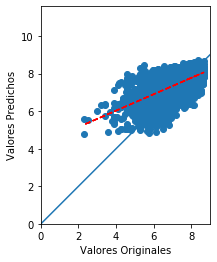

0.36844725265449085

In [27]:
model = ep.build_model(train_dataset)
ep.train_model(model, train_dataset, train_labels, 250)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, model)

### Subconjunto Literatura RF - Regresión Lineal con constante

----Resultados sobre TRAIN----
R2:  0.15109932916781754
Adjusted R2:  0.15071939450982907
MAPE: 66.6958379803148
----Resultados sobre TEST----
R2:  0.1672825453895781
Adjusted R2:  0.16616342684827168
MAPE: 66.12895787586672


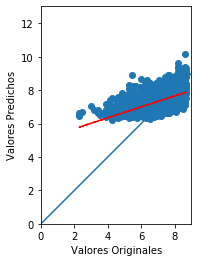

0.1672825453895781

In [28]:
lr = LinearRegression(fit_intercept=True)
lr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, lr)

### Subconjunto Literatura RF - Random Forest

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


----Resultados sobre TRAIN----
R2:  0.8405588846221408
Adjusted R2:  0.8404875250299979
MAPE: 20.042025925046875
----Resultados sobre TEST----
R2:  0.2810522450903252
Adjusted R2:  0.28008602568625796
MAPE: 58.54189720626095


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


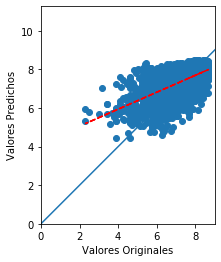

0.2810522450903252

In [29]:
regressor = RandomForestRegressor(100, criterion="mae", verbose=1, n_jobs=4)
regressor.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, regressor)

### Subconjunto Literatura RF - Regresión de Soporte Vectorial

----Resultados sobre TRAIN----
R2:  0.17586716776390732
Adjusted R2:  0.17549831821941853
MAPE: 74.66352465939039
----Resultados sobre TEST----
R2:  0.19004314023593838
Adjusted R2:  0.18895461046584439
MAPE: 73.9083783488769


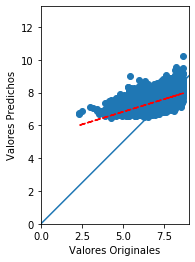

0.19004314023593838

In [30]:
svr = svm.SVR(kernel='linear')
svr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, svr)

# Subconjunto Todo con filtro correlación 0.1


In [12]:
todo_corr = ['TRIMESTRE_2018Q3', 'TIPO_PENSION_SOLO_ALOJAMIENTO', 'SERV_TRANSFERS',
             'PROPOSITO_NEGOCIOS_TRABAJO', 'PERSONAS_TOTAL',
             'PAQUETE_TURISTICO_SI', 'NOCHES_TF', 'NOCHES_LZ', 'NOCHES',
             'NACIONALIDAD_ESP724', 'MOTIVACION_1_DISFRUTAR_FAMILIA', 'INGRESOS',
             'HORAS_DIA', 'GRATIS_ALOJ', 'EDAD', 'COMPRA_ALOJ_COMPANNIA_ALOJAMIENTO',
             'COMPANNIA_SOLO', 'COMPANNIA_OTROS_FAMILIARES', 'COMPANNIA_HIJOS',
             'CANAL_TOUROPERADOR_AGENCIA_VIAJE', 'ANTELACION_VIAJE_MAS_DE_6_MESES',
             'ANTELACION_VIAJE_1-15_DIAS', 'ALOJ_CATEG_PARTICULAR',
             'ALOJ_CATEG_HOTEL5', 'ACTIV_PISCINA', 'ACTIV_PARQUES_OCIO']

#### Antes de evaluar los modelos con estas variables, vamos a echar un vistazo a su FIV para asegurarnos de que no haya multicolinealidad

In [13]:
X = dp.load_dataset('./datos/GASTO_TURISTICO_2018_ORIGINAL_2.csv', ';', ',', predictors=todo_corr, dummies=True, desglose=False)
print(X.shape)
scaler = StandardScaler()

y = X.pop('GASTO')
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
fs.check_vif(X)

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\amct2\PycharmProjects\tfg\data_preprocessing.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = x[(y > q1 - IQR)]


(35767, 27)
         VIF                          variables
0   1.118424                   TRIMESTRE_2018Q3
1   1.288767      TIPO_PENSION_SOLO_ALOJAMIENTO
2   2.063816                     SERV_TRANSFERS
3   1.156468         PROPOSITO_NEGOCIOS_TRABAJO
4   1.979072                     PERSONAS_TOTAL
5   2.704209               PAQUETE_TURISTICO_SI
6   1.278403                          NOCHES_TF
7   1.174109                          NOCHES_LZ
8   1.327974                             NOCHES
9   1.258623                NACIONALIDAD_ESP724
10  1.234424     MOTIVACION_1_DISFRUTAR_FAMILIA
11  1.092209                           INGRESOS
12  1.180330                          HORAS_DIA
13  1.509314                        GRATIS_ALOJ
14  1.209182                               EDAD
15  1.413858  COMPRA_ALOJ_COMPANNIA_ALOJAMIENTO
16  1.392374                     COMPANNIA_SOLO
17  1.257466         COMPANNIA_OTROS_FAMILIARES
18  1.686063                    COMPANNIA_HIJOS
19  1.198588   CANAL_TOUROPE

En principio parece que no hemos detectado ningún FIV alarmante (en torno a 5), por lo que procederemos a predecir con nuestro subconjunto.

In [14]:
X['GASTO'] = np.log(y)

train_dataset, test_dataset = dp.split_dataset(X)
train_labels = train_dataset.pop('GASTO')
test_labels = test_dataset.pop('GASTO')

### Subconjunto Todo con correlación 0.1 - Red Neuronal 

Train on 17972 samples, validate on 8853 samples
Epoch 1/250
 - 1s - loss: 0.6509 - mean_absolute_error: 0.6509 - mean_squared_error: 1.1647 - val_loss: 0.4223 - val_mean_absolute_error: 0.4223 - val_mean_squared_error: 0.3267
Epoch 2/250
 - 1s - loss: 0.3967 - mean_absolute_error: 0.3967 - mean_squared_error: 0.3035 - val_loss: 0.3834 - val_mean_absolute_error: 0.3834 - val_mean_squared_error: 0.2797
Epoch 3/250
 - 1s - loss: 0.3760 - mean_absolute_error: 0.3760 - mean_squared_error: 0.2775 - val_loss: 0.3691 - val_mean_absolute_error: 0.3691 - val_mean_squared_error: 0.2825
Epoch 4/250
 - 1s - loss: 0.3616 - mean_absolute_error: 0.3616 - mean_squared_error: 0.2642 - val_loss: 0.4060 - val_mean_absolute_error: 0.4060 - val_mean_squared_error: 0.3226
Epoch 5/250
 - 1s - loss: 0.3559 - mean_absolute_error: 0.3559 - mean_squared_error: 0.2569 - val_loss: 0.3610 - val_mean_absolute_error: 0.3610 - val_mean_squared_error: 0.2692
Epoch 6/250
 - 1s - loss: 0.3512 - mean_absolute_error: 0.351

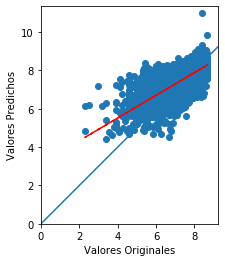

0.23273658690669685

In [15]:
model = ep.build_model(train_dataset)
ep.train_model(model, train_dataset, train_labels, 250)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, model)

### SubconjuntoTodo por correlación 0.1 - Regresión Lineal con constante

----Resultados sobre TRAIN----
R2:  0.4690252266377003
Adjusted R2:  0.46851006341255585
MAPE: 46.98812260730937
----Resultados sobre TEST----
R2:  0.4521904698356166
Adjusted R2:  0.450592820056113
MAPE: 47.57983904831183


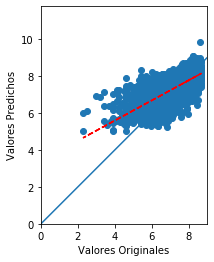

0.4521904698356166

In [37]:
lr = LinearRegression(fit_intercept=True)
lr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, lr)

### Subconjunto Todo por correlación 0.1 - Random Forest

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 12.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


----Resultados sobre TRAIN----
R2:  0.9073159711553271
Adjusted R2:  0.9072260471031605
MAPE: 13.996735615290836
----Resultados sobre TEST----
R2:  0.48806245061750275
Adjusted R2:  0.48656941906574225
MAPE: 43.590879506749296


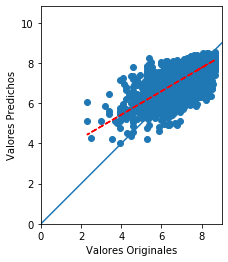

0.48806245061750275

In [38]:
regressor = RandomForestRegressor(100, criterion="mae", verbose=1, n_jobs=4)
regressor.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, regressor)

### Subconjunto Todo por correlación 0.1 - Regresión de Soporte Vectorial

----Resultados sobre TRAIN----
R2:  0.48731465029850374
Adjusted R2:  0.4868172318683135
MAPE: 51.649728864433996
----Resultados sobre TEST----
R2:  0.4683630478029953
Adjusted R2:  0.46681256426321716
MAPE: 52.136896025833565


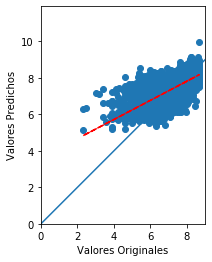

0.4683630478029953

In [39]:
svr = svm.SVR(kernel='linear')
svr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, svr)

### Subconjunto Todo por correlación 0.1 - Regresión de Soporte Vectorial rbf

----Resultados sobre TRAIN----
R2:  0.6590703111642804
Adjusted R2:  0.6587395337962033
MAPE: 38.84179431041076
----Resultados sobre TEST----
R2:  0.5306575849429708
Adjusted R2:  0.5292887792456648
MAPE: 46.89430484740063


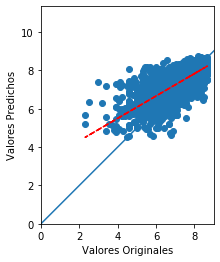

0.5306575849429708

In [40]:
svr = svm.SVR(kernel='rbf')
svr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, svr)

# Subconjunto Todo con RF


In [42]:
todo_rf = ['IMPORTANCIA_OFERTA_CULTURAL', 'IMPORTANCIA_AUTENTICIDAD', 'IMPORTANCIA_VIAJE_SENCILLO', 'IMPORTANCIA_EXOTISMO',
           'NOCHES_TF', 'IMPORTANCIA_OFERTA_COMERCIAL', 'VISITAS_TOTAL_FV', 'IMPORTANCIA_EUROPA', 'IMPORTANCIA_DIVERSION',
           'RECOMENDAR_CANARIAS', 'IMPORTANCIA_GASTRONOMIA', 'VISITAS_TOTAL_LZ', 'INGRESOS', 'VISITAS_TOTAL_GC',
           'VOLVER_A_CANARIAS', 'PERSONAS_HOGAR', 'VISITAS_CANARIAS_5_ANNOS', 'NOCHES', 'HORAS_DIA', 'EDAD']

#### Antes de evaluar los modelos con estas variables, vamos a echar un vistazo a su FIV para asegurarnos de que no haya multicolinealidad

In [43]:
X = dp.load_dataset('./datos/GASTO_TURISTICO_2018_ORIGINAL_2.csv', ';', ',', predictors=todo_rf, dummies=True, desglose=False)
print(X.shape)
scaler = StandardScaler()

y = X.pop('GASTO')
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
fs.check_vif(X)

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\amct2\PycharmProjects\tfg\data_preprocessing.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = x[(y > q1 - IQR)]


(35767, 13)
         VIF                 variables
0   1.127910                 NOCHES_TF
1   1.093254          VISITAS_TOTAL_FV
2   2.814314       RECOMENDAR_CANARIAS
3   1.091927          VISITAS_TOTAL_LZ
4   1.057066                  INGRESOS
5   1.224232          VISITAS_TOTAL_GC
6   2.860595         VOLVER_A_CANARIAS
7   1.041735            PERSONAS_HOGAR
8   1.349950  VISITAS_CANARIAS_5_ANNOS
9   1.170067                    NOCHES
10  1.022599                 HORAS_DIA
11  1.116687                      EDAD


En principio parece que no hemos detectado ningún FIV alarmante (en torno a 5), por lo que procederemos a predecir con nuestro subconjunto.

In [44]:
X['GASTO'] = np.log(y)

train_dataset, test_dataset = dp.split_dataset(X)
train_labels = train_dataset.pop('GASTO')
test_labels = test_dataset.pop('GASTO')

### Subconjunto Todo con Rf - Red Neuronal 

Train on 17972 samples, validate on 8853 samples
Epoch 1/250
 - 1s - loss: 0.7506 - mean_absolute_error: 0.7506 - mean_squared_error: 1.7067 - val_loss: 0.5486 - val_mean_absolute_error: 0.5486 - val_mean_squared_error: 0.5738
Epoch 2/250
 - 1s - loss: 0.4839 - mean_absolute_error: 0.4839 - mean_squared_error: 0.4518 - val_loss: 0.4840 - val_mean_absolute_error: 0.4840 - val_mean_squared_error: 0.4172
Epoch 3/250
 - 1s - loss: 0.4686 - mean_absolute_error: 0.4686 - mean_squared_error: 0.4303 - val_loss: 0.4626 - val_mean_absolute_error: 0.4626 - val_mean_squared_error: 0.4101
Epoch 4/250
 - 1s - loss: 0.4590 - mean_absolute_error: 0.4590 - mean_squared_error: 0.4178 - val_loss: 0.4498 - val_mean_absolute_error: 0.4498 - val_mean_squared_error: 0.3999
Epoch 5/250
 - 1s - loss: 0.4544 - mean_absolute_error: 0.4544 - mean_squared_error: 0.4095 - val_loss: 0.4542 - val_mean_absolute_error: 0.4542 - val_mean_squared_error: 0.4191
Epoch 6/250
 - 1s - loss: 0.4515 - mean_absolute_error: 0.451

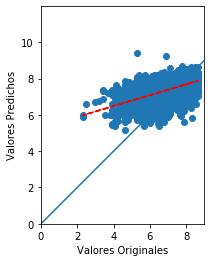

0.2002848302187672

In [45]:
model = ep.build_model(train_dataset)
ep.train_model(model, train_dataset, train_labels, 250)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, model)

### SubconjuntoTodo con RF - Regresión Lineal con constante

----Resultados sobre TRAIN----
R2:  0.07361318270604666
Adjusted R2:  0.07319856828684901
MAPE: 77.89096949397423
----Resultados sobre TEST----
R2:  0.0380038607996096
Adjusted R2:  0.03671100004584038
MAPE: 77.17212055151188


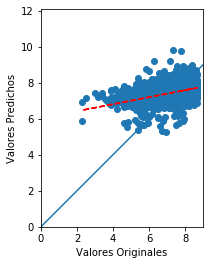

0.0380038607996096

In [46]:
lr = LinearRegression(fit_intercept=True)
lr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, lr)

### Subconjunto Todo con RF - Random Forest

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


----Resultados sobre TRAIN----
R2:  0.8342745389416508
Adjusted R2:  0.8342003667227675
MAPE: 19.290040127676278
----Resultados sobre TEST----
R2:  0.1597448972033323
Adjusted R2:  0.15861564854910892
MAPE: 64.60550832703579


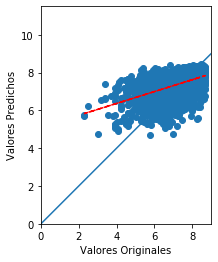

0.1597448972033323

In [47]:
regressor = RandomForestRegressor(100, criterion="mae", verbose=1, n_jobs=4)
regressor.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, regressor)

### Subconjunto Todo con RF - Regresión de Soporte Vectorial

----Resultados sobre TRAIN----
R2:  0.037008332503728036
Adjusted R2:  0.03657733518872153
MAPE: 87.00995629583892
----Resultados sobre TEST----
R2:  -0.05029254223872481
Adjusted R2:  -0.05170406766227331
MAPE: 85.95288097551061


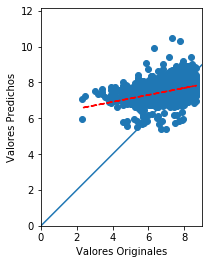

-0.05029254223872481

In [48]:
svr = svm.SVR(kernel='linear')
svr.fit(train_dataset, train_labels)
cm.evaluate_log_lin(test_dataset, test_labels, train_dataset, train_labels, svr)